<a href="https://colab.research.google.com/github/AlexHuang21/2048/blob/main/5450_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project for CIS 5450: Detecting depression in tweets using Sentiment Analysis and an LSTM recurrent neural network

Hope you enjoy looking through our work!

# Libraries and Setup

Let's start by importing the necessary libraries:

In [ ]:
# Install and import the necessary libraries
!pip install word2vec
!pip install nltk # For tokenizing and other preprocessing
!pip install kaggle
!pip install gensim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import json
from gensim.models import Word2Vec
from wordcloud import WordCloud


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


And then the following dataset, so we can use it to perform analysis on and train our model:

** NOTE, it is required that you download the tweet dataset from [here](https://www.kaggle.com/datasets/gargmanas/sentimental-analysis-for-tweets) and move the csv file inside the content directory. The Kaggle API wasn't working for our group, so we had to work around it.

In [ ]:
# Importing the kaggle dataset

raw_df = pd.read_csv('/content/sentiment_tweets3.csv')
filtered_df = raw_df[['message to examine', 'label (depression result)']]
renamed_df = filtered_df.rename(columns={'message to examine': 'tweet', 'label (depression result)': 'label'})
renamed_df.head(25)

,tweet,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,dont mistake a bad day with depression! everyo...,1


# Exploratory Data Analysis

In this section, we will perform some basic exploratory data analysis on the raw data provided by the Kaggle dataset. We will explore the dataset and generate visualizations to better understand the data. We will also create various plots, such as bar plots, scatter plots, histograms, and a wordcloud. Lastly, we will calculate summary statistics and examine at the correlation matrix.

We begin with a distribution analysis of the classification labels in the dataset.

This code creates a bar plot that displays the frequency distribution of the depression classification labels in the dataset. This allows us to gain a better understanding of the distribution of depression classification labels in the dataset. By visualizing the frequency distribution of the labels using a bar plot, we can see how many tweets are classified as 'Depressed' or 'Not Depressed' and get a sense of the overall balance of the dataset. This information can help we determine if any further preprocessing or stratification is needed before training a classification model.

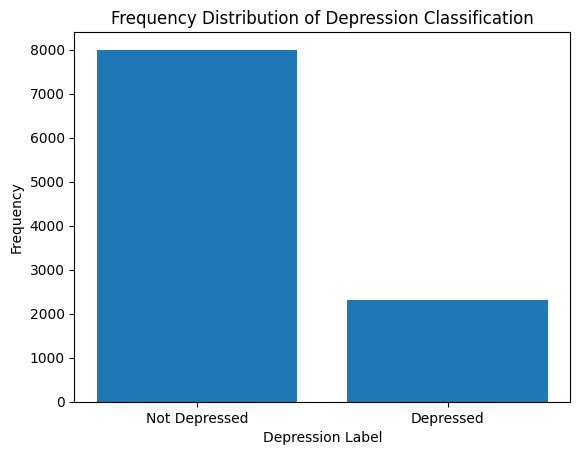

In [ ]:
# Define the target variable, which in this case is the labels provided for the tweets
target_variable = 'label'

# Obtain the frequencies of each label for the tweets
class_count = renamed_df[target_variable].value_counts()

# Generate a bar plot for the different counts of the labels
plt.bar(class_count.index, class_count.values)
plt.title('Frequency Distribution of Depression Classification')
plt.xlabel('Depression Label')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Not Depressed', 'Depressed'])
plt.show()

This suggests that the dataset may be imbalanced, with a much larger number of 'Not Depressed' tweets than 'Depressed' tweets. This can be problematic for training a classification model because an imbalanced dataset can bias the model towards the majority class, resulting in poor performance on the minority class. Therefore, this result highlights the need to balance the dataset before training a classification model in our preprocessing phase.

We're now going to focus on analyzing the tweets themselves. We begin by converting the tweets from objects to strings for further analysis on the string tweets.

In [ ]:
renamed_df['tweet'] = renamed_df['tweet'].astype('string')
renamed_df['tweet length'] = renamed_df['tweet'].str.len()

After the conversion of the tweets themselves to strings, we are going to investigate the summary statistics on the tweets, finding information on the distribution of tweet lengths.

This allows us to understand the distribution of tweet lengths in the dataset and to assess the overall quality of the data. The statistics generated can also help us identify any issues with the data, such as missing values or outliers, that may need to be addressed before building a classification model.

In [ ]:
# Obtain summary statistics on the length of the tweets and store them in new variables
count = renamed_df['tweet length'].count()
mean = renamed_df['tweet length'].mean()
std = renamed_df['tweet length'].std()
min_val = renamed_df['tweet length'].min()
twenty_five_perc = renamed_df['tweet length'].quantile(0.25)
median = renamed_df['tweet length'].median()
seventy_five_perc = renamed_df['tweet length'].quantile(0.75)
max_val = renamed_df['tweet length'].max()


T# Provide the summary statistics in tabular form
renamed_df[['tweet length']].describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,tweet length
count,10314.000000
mean,92.616153
std,64.670905
min,1.000000
25%,48.000000
50%,78.000000
75%,119.000000
max,874.000000


The mean length of 92.62 characters suggests that the average tweet in the dataset is relatively short, but with a standard deviation of 64.67 characters, we can see that there is significant variation in the length of the tweets. The minimum value of 1 character and the maximum value of 874 characters also suggest that the dataset contains some extreme values or outliers.


We are now going to provide a histogram visualization of the tweet lengths.
This provides important information about the distribution of tweet lengths in the dataset, which can guide preprocessing and feature engineering for the classification model.

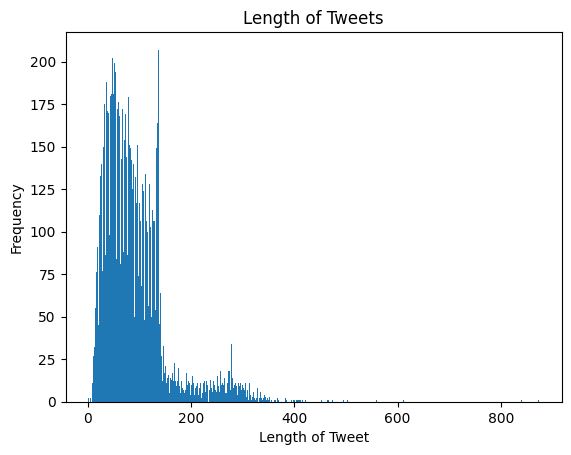

In [ ]:
# Generate histogram for the data length
plt.hist(renamed_df['tweet'].str.len(), bins=500)
plt.title('Length of Tweets')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

This suggests that there is a relatively narrow range of tweet lengths in the dataset. This can be useful information for preprocessing the data, as it may allow us to set an appropriate maximum length for the input sequences in the classification model.

We are now curious to see a scatterplot of the lengths of the tweets sorted by the labels.

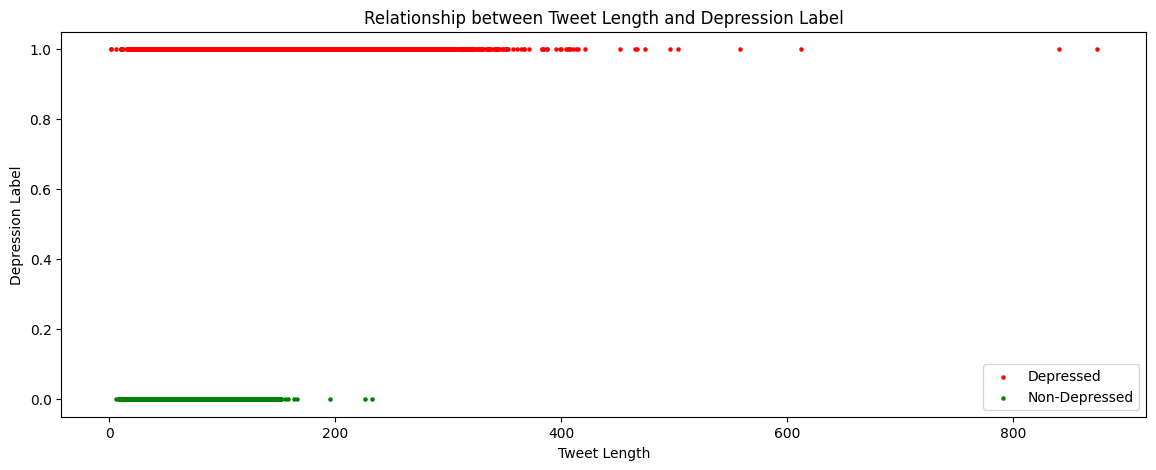

In [ ]:
plt.figure(figsize=(14, 5))

depressed_tweets = renamed_df[renamed_df['label'] == 1]
non_depressed_tweets = renamed_df[renamed_df['label'] == 0]

plt.scatter(depressed_tweets['tweet length'], depressed_tweets['label'], color='red', label='Depressed', s=5)
plt.scatter(non_depressed_tweets['tweet length'], non_depressed_tweets['label'], color='green', label='Non-Depressed', s=5)

plt.title('Relationship between Tweet Length and Depression Label')
plt.xlabel('Tweet Length')
plt.ylabel('Depression Label')

plt.legend(loc='best')
plt.show()

This suggests that tweet length may be a useful feature for predicting depression labels. Also, it provides insight into the nature of tweets about depression. For example, longer tweets about depression may be more likely to contain more detailed or personal information about a person's experience with depression.

As a result of the seemingly disparate distribution between lengths of tweets with different labels. We now will generate a boxplot to visualize the distribution alongside the range of the tweet lengths by label.

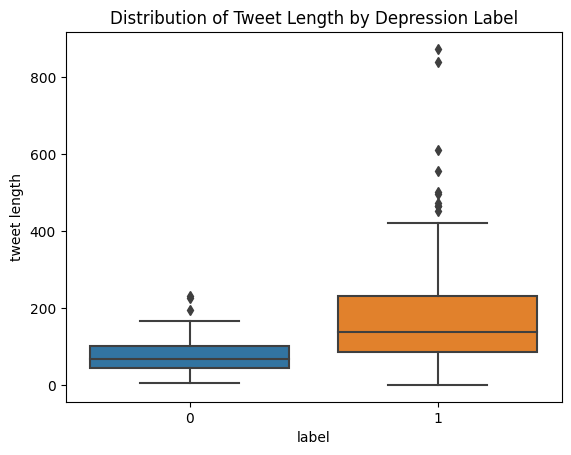

In [ ]:
sns.boxplot(x='label', y='tweet length', data=renamed_df)
plt.title('Distribution of Tweet Length by Depression Label')
plt.show()

We also wanted to generate a wordcloud of the tweets in the dataset, to identify the most frequently occuring words. This wordcloud can provide insights into the most common themes and topics discussed in tweets about depression, and can guide the development of the classification model by highlighting important features or keywords that may be useful for predicting depression labels.

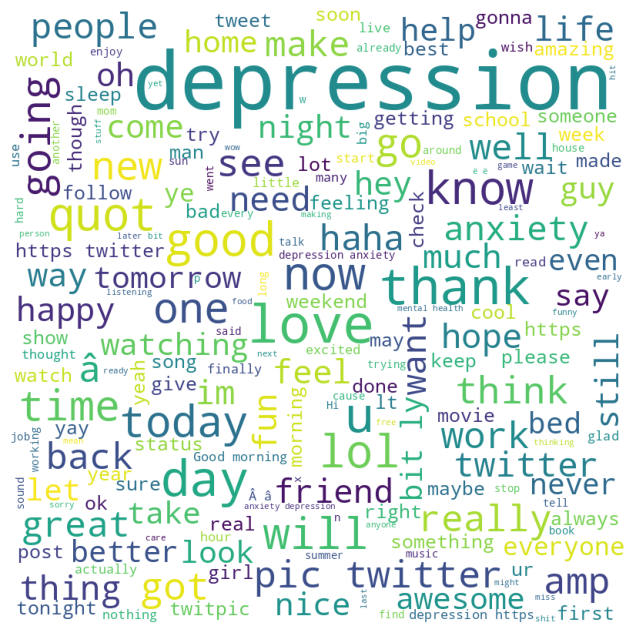

In [ ]:
# We begin by combining all the tweets into a single list
all_tweets = ' '.join(renamed_df['tweet'].tolist())

# We then generate a wordcloud from the list
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=None, min_font_size=10).generate(all_tweets)

# Display the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We now collect the number of words in each tweet and the most commonly occuring word in each tweet. We put these results into new columns. The most common word in each tweet and the number of words in each tweet are both potentially useful features for predicting depression labels, as they may be associated with the sentiment or emotional state of the tweeter.

In [ ]:
# Create a function to get the most common word and number of words in each tweet
def get_word_and_length(tweet):
    words = tweet.split()
    word_counts = pd.Series(words).value_counts()
    most_common_word = word_counts.index[0]
    num_words = len(words)
    return pd.Series({'Most Common Word': most_common_word, 'Num Words': num_words})

# Apply the function and store the results in a new column
renamed_df[['Most Common Word', 'Num Words']] = renamed_df['tweet'].apply(get_word_and_length)

We now identify the number of occurences of hashtags and words associated with depression. We intend to use these to develop a correlation identification matrix.

In [ ]:
from collections import Counter
import re

# Define a regex pattern to match hashtags
hashtag_pattern = re.compile(r'#\w+')

# Define a list of words and hashtags related to depression
depression_words = ['depressed', 'sad', 'anxious', 'lonely', 'suicidal']
depression_hashtags = ['#depression', '#mentalhealth', '#anxiety', '#mentalillness']

# Calculate the frequency of each depression-related word/hashtag in each tweet
depression_counts = renamed_df['tweet'].apply(lambda x: Counter(x.lower().split())).apply(lambda x: sum([x.get(word, 0) for word in depression_words]))
hashtag_counts = renamed_df['tweet'].apply(lambda x: Counter(re.findall(hashtag_pattern, x.lower()))).apply(lambda x: sum([x.get(hashtag, 0) for hashtag in depression_hashtags]))

# Add the depression counts as a new column in the dataframe
renamed_df['Depressed Words'] = depression_counts

# Add the hashtag counts as a new column in the dataframe
renamed_df['Depressed Hashtags'] = hashtag_counts

Provide the correlation matrix and a heatmap associated with the new calculated data on depressed tweet/word frequencies, number of words, and tweet length.

<ipython-input-12-7ac4629e8dfa>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = renamed_df.corr()


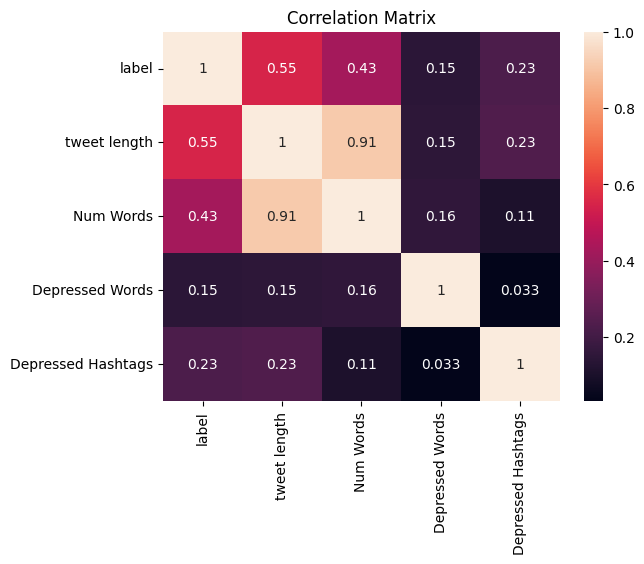

In [ ]:
corr_matrix = renamed_df.corr()

sns.heatmap(np.abs(corr_matrix), annot=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
print(renamed_df.nunique(axis=0))

tweet                 10282
label                     2
tweet length            366
Most Common Word       4896
Num Words                68
Depressed Words           3
Depressed Hashtags        6
dtype: int64


The 'tweet' column contains 10282 unique tweets, indicating that there are no duplicate tweets in the dataset.

The 'label' column contains two unique values (0 and 1), indicating that there are two possible classifications for each tweet (depressed or not depressed).

The 'tweet length' column contains 366 unique values, indicating that there is a wide range of tweet lengths in the dataset.

The 'Most Common Word' column contains 4896 unique values, indicating that there is a wide variety of most common words across the tweets in the dataset.

The 'Num Words' column contains 68 unique values, indicating that there is a relatively narrow range of number of words in each tweet.

The 'Depressed Words' column contains three unique values (0, 1, and 2), indicating that there are three possible values for the frequency of depression-related words in each tweet.

The 'Depressed Hashtags' column contains six unique values, indicating that there are six possible values for the frequency of depression-related hashtags in each tweet.

Overall, these results provide a useful summary of the distribution of values in each column of the dataset, and can guide feature selection and engineering for the classification model.

# Data Preprocessing

In this section, we will perform preprocessing on the raw data in order to gain better usage of it. We will clean and preprocess the text data in preparation for training. We will also apply several text preprocessing techniques, including removing URLs, emojis, punctuation, digits, and stopwords, and stemming words.

We can start by conducting word preprocessing, which can clean and preprocess the raw text data contained in the 'tweet' column of the renamed_df dataframe.

Raw text data can be noisy and unstructured, which can make it difficult to extract meaningful features and build an accurate classification model. By performing preprocessing tasks such as tokenization, stemming, and stopword removal, this code can help to reduce the noise and structure the text data into a more useful format for feature extraction and classification.

In [ ]:
# Word preprocessing

from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re

nltk.download("stopwords")
nltk.download("punkt")

def preprocess_tweet(text):
    # Remove URL's
    pattern = re.compile(r'(https?://\S+)|(www\.\S+)|(\S+\.\S+/\S+)')
    text = pattern.sub(r'', text)

    # Removing emoji's
    pattern2 = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = pattern2.sub(r'', text)

    # Punctuation
    pattern3 = r"[^\w\s]"
    text = re.sub(pattern3, " ", text)

    # Lowercase the text
    text = text.lower()

    # Initialize the stemmer
    stemmer = SnowballStemmer("english")

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation and digits
    tokens = [word for word in tokens if word not in string.punctuation and not word.isdigit()]

    # Remove stopwords
    tokens = [word for word in tokens if word not in set(stopwords.words('english'))]

    # Stem the words
    tokens = [stemmer.stem(word) for word in tokens]

    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now we can conduct additional text cleaning and normalization. These cleaning steps can help to further standardize the text data and reduce noise, making it easier to extract meaningful features and build an accurate classification model. Additionally, these cleaning steps can help to remove any text data that is not relevant to the classification task, such as numbers or special characters.

By applying this function to the 'tweet' column of the renamed_df dataframe, the text data is further cleaned and normalized, which can help to improve the performance of the classification model by reducing noise and increasing the signal-to-noise ratio in the feature space.

In [ ]:
def cleanText(text):
  # Removing repeated tokens
  text =  " ".join( [ re.sub(r'(\w)\1{2,}', r'\1', word) for word in text.split()] )

  # digits
  text = " ".join( [ word for word in text.split() if not re.search(r'\d', word) ] )

  # underscores
  text = " ".join( [ word for word in text.split() if not re.search(r'_|\w*_\w*', word) ] )

  # special characters
  text = " ".join( [ word for word in text.split() if not re.search(r'[^a-zA-Z0-9\s]', word) ] )

  # Remove if less than 2 characters
  return " ".join( [ word for word in text.split() if len(word) > 2 ] )


Now we can put this together so that it is preprocessed. This ensures that the text data is in a consistent and standardized format, which can help to reduce noise and increase the signal-to-noise ratio in the feature space. Additionally, by dropping any rows with empty strings after preprocessing, this code ensures that the data is clean and ready for further processing, which can improve the performance of the classification model.

In [ ]:
# Applying the preprocessing

renamed_df['tweet'] = renamed_df['tweet'].astype('string')


renamed_df['tweet'] = renamed_df['tweet'].apply(lambda x: str(preprocess_tweet(x)));

empty_rows = renamed_df[renamed_df['tweet'].str.strip().eq('')].index

processed_tweet_df = renamed_df.drop(empty_rows)


In [ ]:
processed_tweet_df.head(10)

,tweet,label,tweet length,Most Common Word,Num Words,Depressed Words,Depressed Hashtags
0,real good moment missssssssss much,0,57,just,11,0,0
1,read manga,0,42,is,4,0,0
2,comeagainjen,0,84,@comeagainjen,4,0,0
3,lapcat need send em account tomorrow odd even ...,0,135,to,22,0,0
4,add myspac,0,45,ADD,5,0,0
5,sleepi good time tonight though,0,37,so,6,0,0
6,silkcharm nbn someon alreadi said fiber home m...,0,109,@SilkCharm,21,0,0
7,24ï ½c possibl today nice,0,34,23,6,0,0
8,nite twittervill workout ciao,0,43,nite,7,0,0
9,danann night darlin sweet dream,0,47,@daNanner,7,0,0


Finally, let's apply a second cleaning step to the preprocessed tweet data stored in the processed_tweet_df dataframe. This step ensures that the tweet data is as clean and standardized as possible before proceeding to the feature extraction and classification stages of the pipeline, which can improve the accuracy and robustness of the resulting model.

In [ ]:
# Applying the cleaning

cleaned_tweet_df = processed_tweet_df
print(len(processed_tweet_df))
cleaned_tweet_df['tweet'] = processed_tweet_df['tweet'].apply(lambda x: str(cleanText(x))).astype('string')
empty_rows = cleaned_tweet_df[cleaned_tweet_df['tweet'].str.strip().eq('')].index
final_tweet_df = cleaned_tweet_df.drop(empty_rows).drop(['tweet length'], axis=1)
final_tweet_df = final_tweet_df.sample(frac=1, random_state=42).reset_index(drop=True)

final_tweet_df.head(15)

10307


,tweet,label,Most Common Word,Num Words,Depressed Words,Depressed Hashtags
0,wow depress,1,Wow,4,0,0
1,thank tweet arbonn eye creme giveaway great day,0,@annasmama0702,14,0,0
2,lost subscrib one still well view today appren...,0,i,22,0,0
3,lord pleas help friend deal depress anxieti su...,1,with,44,1,0
4,new album drop soon better get excit,0,the,9,0,0
5,swim right back,0,I'm,8,0,0
6,time bed earli shift tomorrow,0,Time,8,0,0
7,ladi bought bracelet pictur twitter page backg...,0,it,26,0,0
8,skinkl yeah right,0,@skinkl,5,0,0
9,one understand much help serious never better ...,1,in,55,0,0


In [ ]:
final_tweet_df = final_tweet_df[['tweet', 'label']]
final_tweet_df.head(10)

,tweet,label
0,wow depress,1
1,thank tweet arbonn eye creme giveaway great day,0
2,lost subscrib one still well view today appren...,0
3,lord pleas help friend deal depress anxieti su...,1
4,new album drop soon better get excit,0
5,swim right back,0
6,time bed earli shift tomorrow,0
7,ladi bought bracelet pictur twitter page backg...,0
8,skinkl yeah right,0
9,one understand much help serious never better ...,1


# Exploratory Data Analysis Redone

In this section, we will perform the same exploratory data analysis on the data, which is now preprocessed. We will run the same steps as our initial exploratory data analysis on the preprocessed data.

In [ ]:
final_tweet_df['tweet length'] = final_tweet_df['tweet'].str.len()

# Obtain summary statistics on the length of the tweets and store them in new variables
count = final_tweet_df['tweet length'].count()
mean = final_tweet_df['tweet length'].mean()
std = final_tweet_df['tweet length'].std()
min_val = final_tweet_df['tweet length'].min()
twenty_five_perc = final_tweet_df['tweet length'].quantile(0.25)
median = final_tweet_df['tweet length'].median()
seventy_five_perc = final_tweet_df['tweet length'].quantile(0.75)
max_val = final_tweet_df['tweet length'].max()


# Provide the summary statistics in tabular form
final_tweet_df[['tweet length']].describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,tweet length
count,10293.000000
mean,48.767220
std,33.962584
min,3.000000
25%,25.000000
50%,42.000000
75%,62.000000
max,458.000000


We can see that the mean tweet length is 48.77, with a standard deviation of 33.96. This means that the majority of tweets in the dataset are around 50 characters long, with most tweets falling within a range of around 15 to 85 characters.

The minimum tweet length is 3 characters, which suggests that there might be some very short tweets that were not removed during the preprocessing step. On the other hand, the maximum tweet length is 458 characters, which is much lower than the maximum tweet length in the original dataset (874 characters). This suggests that the preprocessing step was effective in removing very long tweets.

The quartile ranges (25th, 50th, and 75th percentiles) show that 25% of tweets are 25 characters or less, 50% of tweets are 42 characters or less, and 75% of tweets are 62 characters or less. This suggests that most tweets in the dataset are relatively short, which could be beneficial for training a machine learning model, as it reduces the complexity of the data.

Overall, these results suggest that the preprocessing step was effective in producing a dataset with tweets that are relatively short and uniform in length, which could potentially improve the performance of a machine learning model trained on the preprocessed dataset.

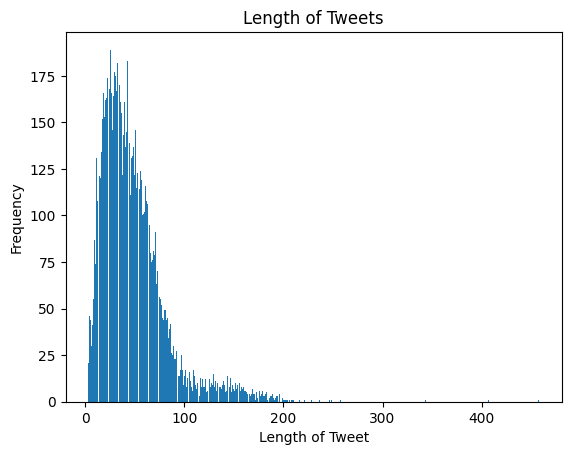

In [ ]:
# Generate histogram for the data length
plt.hist(final_tweet_df['tweet'].str.len(), bins=500)
plt.title('Length of Tweets')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

Based on the histogram plot of tweet lengths in the preprocessed dataset, we can see that the lengths of the tweets are now generally shorter compared to the lengths of the tweets in the original dataset. The majority of the tweet lengths fall between 0 and 90, with the highest frequency being around 20 to 30 characters.

This suggests that the preprocessing step was effective in removing unnecessary information from the tweets, such as URLs, emojis, and stop words, which resulted in shorter and more concise tweets. This could potentially improve the performance of a machine learning model trained on the preprocessed dataset, as shorter and more concise tweets may contain more relevant information for identifying depression-related content.

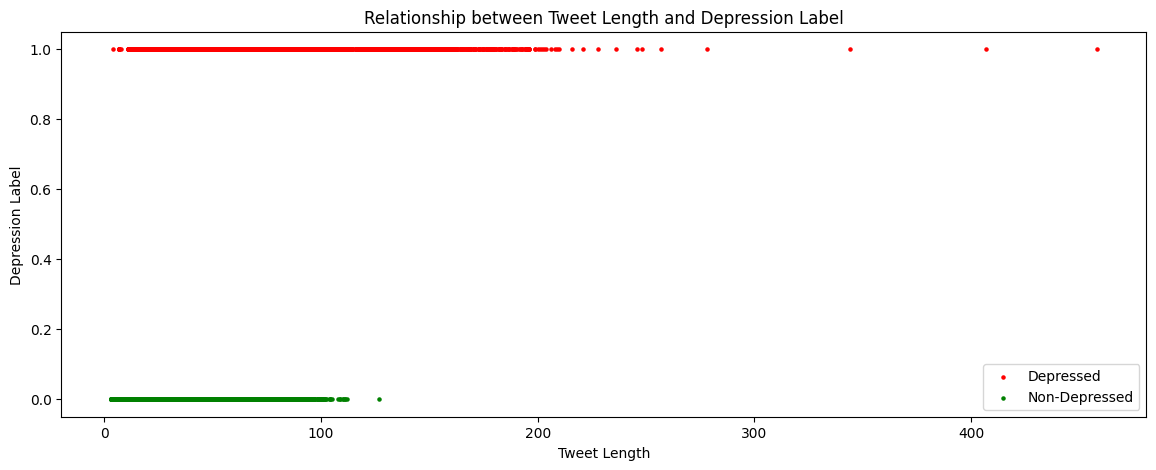

In [ ]:
plt.figure(figsize=(14, 5))

depressed_tweets = final_tweet_df[final_tweet_df['label'] == 1]
non_depressed_tweets = final_tweet_df[final_tweet_df['label'] == 0]

plt.scatter(depressed_tweets['tweet length'], depressed_tweets['label'], color='red', label='Depressed', s=5)
plt.scatter(non_depressed_tweets['tweet length'], non_depressed_tweets['label'], color='green', label='Non-Depressed', s=5)

plt.title('Relationship between Tweet Length and Depression Label')
plt.xlabel('Tweet Length')
plt.ylabel('Depression Label')

plt.legend(loc='best')
plt.show()

Based on the scatter plot of tweet lengths and depression labels in the preprocessed dataset, we can see that the lengths of tweets in both depressed and non-depressed categories have decreased compared to the original dataset. The range of tweet lengths for depressed tweets has reduced from mostly 0-400 to 0-200, while the range for non-depressed tweets has reduced from 0-150 to 0-110.

This suggests that the preprocessing step has effectively removed unnecessary information from the tweets, resulting in shorter and more concise tweets, and that the reduction in tweet lengths is consistent across both depressed and non-depressed categories.

This is again visualized below by the box plot:

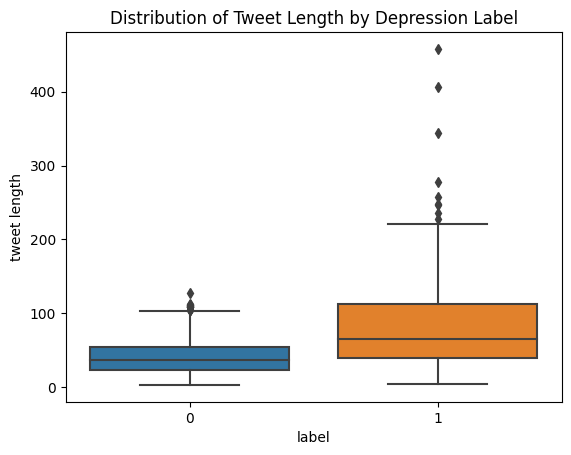

In [ ]:
sns.boxplot(x='label', y='tweet length', data=final_tweet_df)
plt.title('Distribution of Tweet Length by Depression Label')
plt.show()

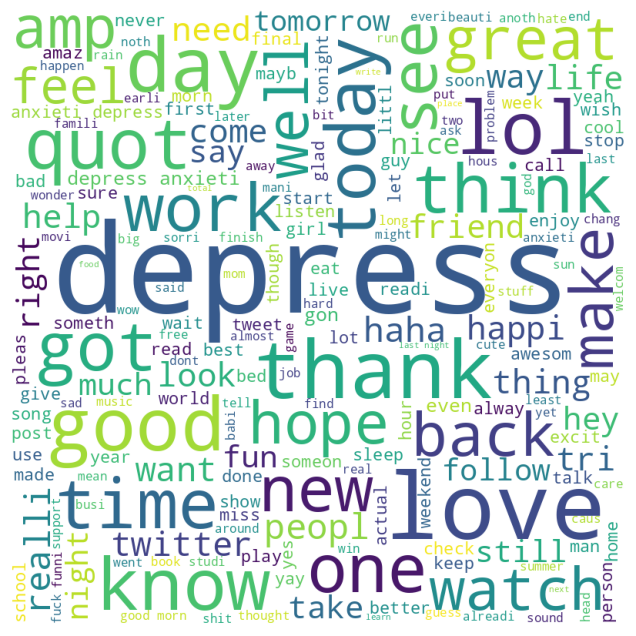

In [ ]:
# We begin by combining all the tweets into a single list
all_tweets = ' '.join(final_tweet_df['tweet'].tolist())

# We then generate a wordcloud from the list
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=None, min_font_size=10).generate(all_tweets)

# Display the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Note that the change in the most common word from "depression" to "depress" is due to the preprocessing step of stemming the vocabulary of words.

As for the other results, it's not surprising to see some differences between the preprocessed and raw data analyses, as the preprocessing steps can have an impact on the frequencies and patterns of words used in the tweets. However, it's also possible that many of the overall trends and patterns remain consistent between the two analyses.

In [ ]:
# Define a regex pattern to match hashtags
hashtag_pattern = re.compile(r'#\w+')

# Define a list of words and hashtags related to depression
depression_words = ['depressed', 'sad', 'anxious', 'lonely', 'suicidal']
depression_hashtags = ['#depression', '#mentalhealth', '#anxiety', '#mentalillness']

# Calculate the frequency of each depression-related word/hashtag in each tweet
depression_counts = final_tweet_df['tweet'].apply(lambda x: Counter(x.lower().split())).apply(lambda x: sum([x.get(word, 0) for word in depression_words]))
hashtag_counts = final_tweet_df['tweet'].apply(lambda x: Counter(re.findall(hashtag_pattern, x.lower()))).apply(lambda x: sum([x.get(hashtag, 0) for hashtag in depression_hashtags]))

# Add the depression counts as a new column in the dataframe
final_tweet_df['Depressed Words'] = depression_counts

# Add the hashtag counts as a new column in the dataframe
final_tweet_df['Depressed Hashtags'] = hashtag_counts

<ipython-input-27-6d116f17302b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = final_tweet_df.corr()


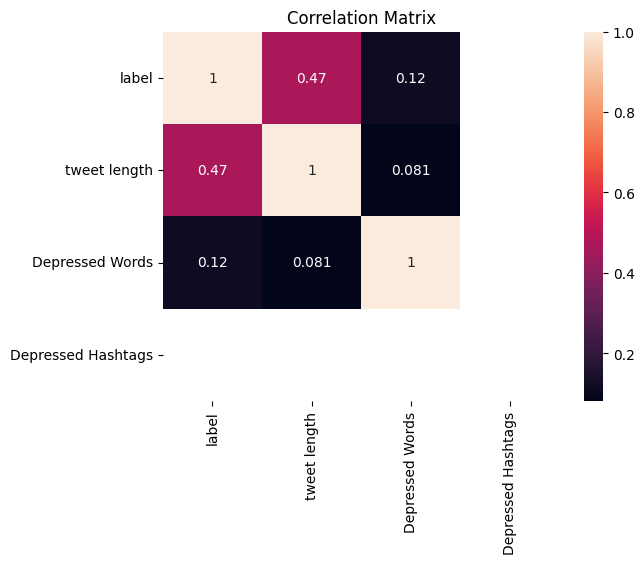

In [ ]:
corr_matrix = final_tweet_df.corr()

sns.heatmap(np.abs(corr_matrix), annot=True)
plt.title('Correlation Matrix')
plt.show()

This shows that we have removed the 'num words' variable as it was pretty much the same as the tweet length variable, and that we have removed this redundancy.

In [ ]:
print(final_tweet_df.nunique(axis=0))

tweet                 10113
label                     2
tweet length            215
Depressed Words           3
Depressed Hashtags        1
dtype: int64


We can see that the number of unique tweets decreased from 10,282 to 10,113 after preprocessing. This is expected as some tweets might have been removed during the preprocessing steps. The number of unique labels remains the same at 2. However, the number of unique values in the tweet length column decreased from 366 to 215, indicating that some values were removed or modified during the preprocessing steps. Additionally, the number of unique values in the Depressed Words column remains the same at 3.

# Training our Models

The training section is where we build and train our machine learning models to classify tweets as either indicating depression or not. Once we are satisfied with our model's performance, we can then use it to make predictions on new, unseen data.

First, we must prepare the preprocessed data for modeling using three different models: random forest, naive bayes, and LSTM. We start by importing libraries for these models.

In [ ]:
# Preparing for the data for modeling with random forest,
# naive bayes, and then LSTM

!pip install tensorflow
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

X = final_tweet_df['tweet']
y = final_tweet_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Defining imports for Random Forest Classification and Naive Bayes Classification

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

Next, we will use TF-IDF (term frequency-inverse document frequency) vectorizer to convert the preprocessed tweet text data into a numerical format that can be used by machine learning algorithms for classification. By using a vectorizer to format the data, we can ensure that our models are able to work with the data and provide accurate results. In addition, using a vectorizer also helps to reduce the dimensionality of the data, which can improve the performance of the models.

In [ ]:
# Using a vectorizer to format the data

max_features = 10000  # You can adjust this parameter

vectorizer = TfidfVectorizer(max_features=max_features)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


Now we can train our model. Training a random forest model on the preprocessed and vectorized data is significant because it allows us to build a predictive model that can classify new tweets as either depressed or not depressed based on their text content.

In [ ]:
# Training the model

rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Now we will evaulate the performance of the trained random forest model on the test set. This information is important to assess the performance of the model and determine if it is accurately predicting the labels of the test set.

In [ ]:
# Evaluating the model

y_pred_rf = rf_model.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Test Accuracy:", accuracy_rf)
print(classification_report(y_test, y_pred_rf))

Random Forest Test Accuracy: 0.9951432734337057
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1597
           1       1.00      0.98      0.99       462

    accuracy                           1.00      2059
   macro avg       1.00      0.99      0.99      2059
weighted avg       1.00      1.00      1.00      2059



The accuracy of the Random Forest model on the test data was 0.995, which is very high. This means that the model was able to correctly classify 99.5% of the test data. Furthermore, the precision, recall, and F1-score metrics for both the non-depressed and depressed classes were also high, indicating that the model was able to accurately predict both classes. Overall, our results indicate that the Random Forest model performed very well on the test data, which is a great sign for us and is indicitave that it may be effective for classifying new data.

Next, we can initialize and train a Naive Bayes multinomial classifier on the preprocessed and vectorized text data. By fitting the model on the training data, it learns to predict the class labels for the test data based on the probability distribution of the words in the training data.

In [ ]:
# NB multinomial classifier

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

Similarly to the last model, we will and evaluate the performance of a Naive Bayes classifier on our preprocessed and vectorized dataset. This is significant because it allows us to compare the performance of our Naive Bayes model with other models that we train later on in the project, such as LSTM.

In [ ]:
# Evaluating the performance of NB

y_pred_nb = nb_model.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Test Accuracy:", accuracy_nb)
print(classification_report(y_test, y_pred_nb))

Naive Bayes Test Accuracy: 0.9184069936862554
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1597
           1       0.98      0.65      0.78       462

    accuracy                           0.92      2059
   macro avg       0.95      0.82      0.87      2059
weighted avg       0.92      0.92      0.91      2059



The Naive Bayes classifier still has good scores, but it has a lower accuracy of 0.918, with precision and recall scores of 0.91-1.00 for non-depressed tweets and 0.98-0.65 for depressed tweets. This indicates that the model is less accurate than the Random Forest classifier, especially in identifying depressed tweets, where the recall score is relatively low.

In this next code block, we are preparing the data for the LSTM model. We are using the Tokenizer class from the Keras library to convert the text into sequences of integers. We are also computing sample weights to handle class imbalances in the training data. This is important because imbalanced classes can lead to biased models that perform poorly on the underrepresented class.

In [ ]:
# Now, we try with an LSTM model
from sklearn.utils import compute_sample_weight

tokenizer = Tokenizer(num_words=max_features, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Handle class imbalances
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

Next, we will pad the sequences. This step is important as it helps to ensure that all input sequences have the same length, which is required for training a neural network like LSTM. The padding is done by adding zeros to the start or end of the sequences, depending on the padding parameter.

In [ ]:
# Padding the sequences for LSTM training

max_len = 150
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

Now we can build an LSTM model for the sentiment analysis task. The LSTM model is a type of neural network that can handle sequential data, such as text. The LSTM layer processes the embedded words in a sequence and learns to capture long-term dependencies in the data. Finally, a dense layer with sigmoid activation is added to predict the sentiment label. We are compiling the model using binary cross-entropy loss, Adam optimizer, and accuracy as the evaluation metric.

In [ ]:
# Constructing the LSTM model

embedding_dim = 128
lstm_units = 64

model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], weighted_metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


Next, we can train our LSTM model which is expected to perform better than the traditional machine learning models like Random Forest and Naive Bayes on text classification problems. The use of sample weights to handle class imbalance ensures that the model does not favor one class over the other during training, and the use of the EarlyStopping callback helps prevent overfitting by stopping the training when the validation loss stops improving.

In [ ]:
# Training the LSTM model

batch_size = 32
epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train_padded, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, sample_weight=sample_weights, callbacks=[early_stop])

Epoch 1/10
206/206 [==============================] - 95s 399ms/step - loss: 0.2054 - accuracy: 0.9438 - weighted_accuracy: 0.9123 - val_loss: 0.0258 - val_accuracy: 0.9982 - val_weighted_accuracy: 0.9960
Epoch 2/10
206/206 [==============================] - 59s 289ms/step - loss: 0.0073 - accuracy: 0.9991 - weighted_accuracy: 0.9984 - val_loss: 0.0285 - val_accuracy: 0.9982 - val_weighted_accuracy: 0.9960
Epoch 3/10
206/206 [==============================] - 57s 276ms/step - loss: 0.0029 - accuracy: 0.9998 - weighted_accuracy: 0.9997 - val_loss: 0.0294 - val_accuracy: 0.9982 - val_weighted_accuracy: 0.9960
Epoch 4/10
206/206 [==============================] - 58s 283ms/step - loss: 0.0018 - accuracy: 0.9998 - weighted_accuracy: 0.9997 - val_loss: 0.0289 - val_accuracy: 0.9982 - val_weighted_accuracy: 0.9960


Now, we can evaluate this final model similarly to the way we did with the other models.

In [ ]:
# Evaulating the LSTM Model

test_sample_weights = compute_sample_weight(class_weight='balanced', y=y_test)
loss, accuracy, weighted_accuracy = model.evaluate(X_test_padded, y_test, batch_size=batch_size, sample_weight=test_sample_weights)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Weighted Test Accuracy:", weighted_accuracy)

65/65 [==============================] - 2s 29ms/step - loss: 0.0356 - accuracy: 0.9966 - weighted_accuracy: 0.9924
Test Loss: 0.03562965244054794
Test Accuracy: 0.9966002702713013
Weighted Test Accuracy: 0.9924241304397583


The LSTM model achieved a higher test accuracy of 0.9966 compared to the Random Forest model's accuracy of 0.9951 and the Naive Bayes model's accuracy of 0.9184. This indicates that the LSTM model performed better in predicting depression label based on the preprocessed tweets. This suggests that the LSTM model may be a better choice for depression detection in social media data.

# Analyzing Our Models

This final section involves analyzing the performance of the models trained in the previous section. It utilizes different evaluation metrics like the confusion matrix, recall curve, and bar plot to assess the effectiveness of the models in predicting depression

Let's start by importing all the libraries we'll need to build our visuals that represent the models.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

Firstly, we will build a confusion matrix for each model. The confusion matrix helps us visualize how well our models are performing by showing how many samples were classified correctly and incorrectly for each class (depressed or not depressed).

65/65 [==============================] - 3s 35ms/step


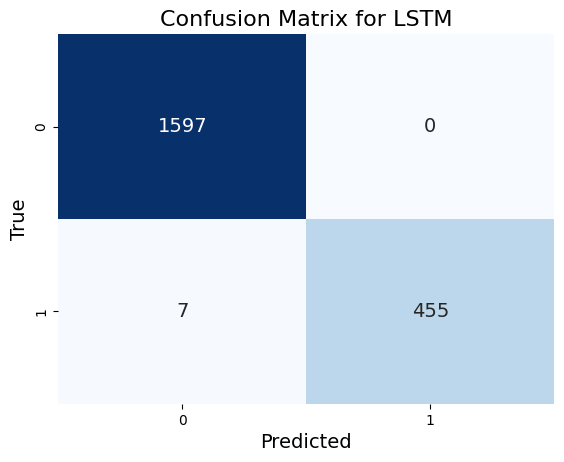

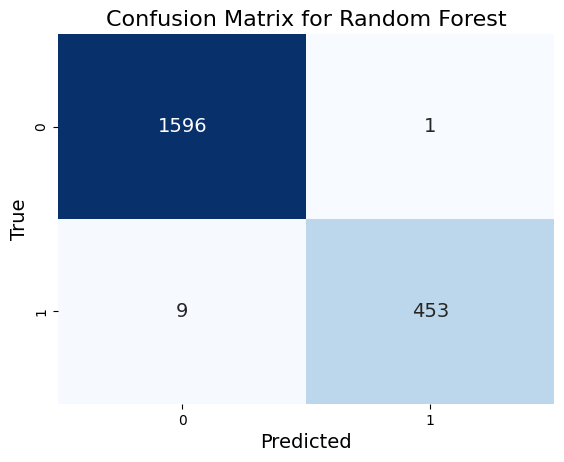

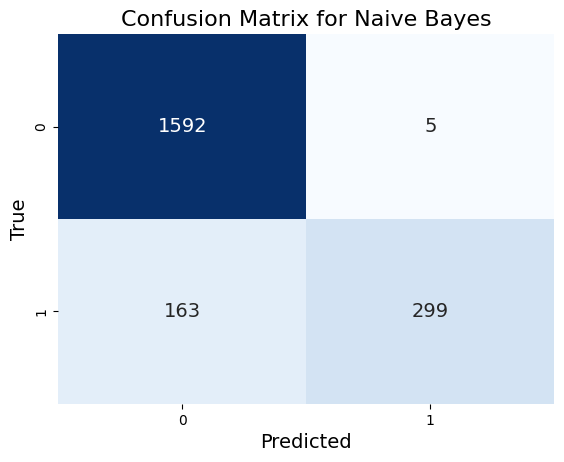

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name, cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, annot_kws={"size": 14})
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("True", fontsize=14)
    plt.title(f"Confusion Matrix for {model_name}", fontsize=16)
    plt.show()

plot_confusion_matrix(y_test, np.round(model.predict(X_test_padded)).astype(int).flatten(), "LSTM")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")

From the confusion matrix, we can see that the LSTM model had the best performance among the three models with the highest number of true positives (455) and true negatives (1597) and the lowest number of false negatives (7). The Random Forest model had the second-best performance with 9 false negatives and 1 false positive. However, the Naive Bayes model performed the worst among the three models with the highest number of false negatives (163) and false positives (5).

Overall, the confusion matrix provides a clear comparison of the performance of the three models in predicting the depression label. The results suggest that the LSTM model outperformed the other two models, and the Random Forest model performed better than the Naive Bayes model. This information is valuable in selecting the best model for deployment in a real-world setting.

2 / 2

This next code generates a precision-recall curve for each of the three models (LSTM, Random Forest, and Naive Bayes) to evaluate their performance in terms of precision and recall. The curve shows how the precision and recall trade off against each other at different probability thresholds for predicting a positive (depressed) label. The closer the curve is to the top right corner of the plot, the better the model's performance in terms of precision and recall.

65/65 [==============================] - 2s 30ms/step


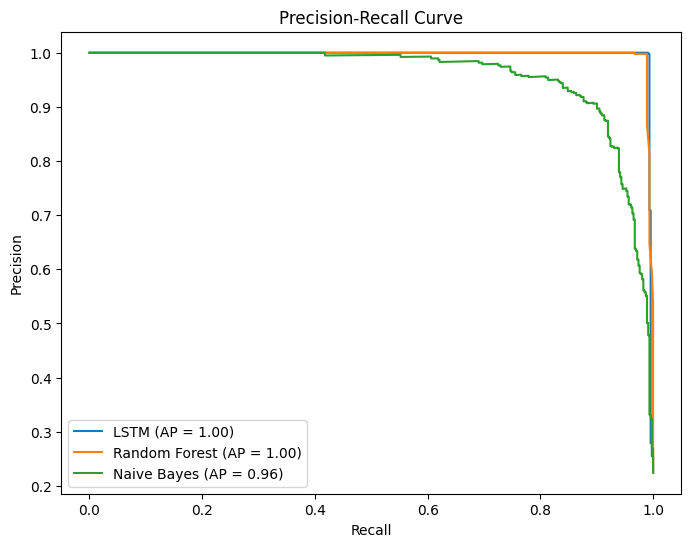

In [ ]:
def plot_precision_recall_curve(y_true, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)
    plt.plot(recall, precision, label=f"{model_name} (AP = {average_precision:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision-Recall Curve")

y_scores_lstm = model.predict(X_test_padded).reshape(-1)
y_scores_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]
y_scores_nb = nb_model.predict_proba(X_test_tfidf)[:, 1]

plt.figure(figsize=(8, 6))
plot_precision_recall_curve(y_test, y_scores_lstm, "LSTM")
plot_precision_recall_curve(y_test, y_scores_rf, "Random Forest")
plot_precision_recall_curve(y_test, y_scores_nb, "Naive Bayes")
plt.show()

By comparing the curves, we can see that the LSTM model outperforms the other two models in terms of precision-recall trade-off. The curve for the LSTM model is the highest and closest to the top right corner of the plot, indicating that it has the highest precision and recall at different probability thresholds. This again suggests that the LSTM model is better at correctly identifying depressed tweets while minimizing the number of false positives.

This final code generates a bar plot comparing the accuracies of the three models - LSTM, Random Forest, and Naive Bayes. The accuracies list contains the accuracy scores of each model, and the model_names list contains the names of each model.

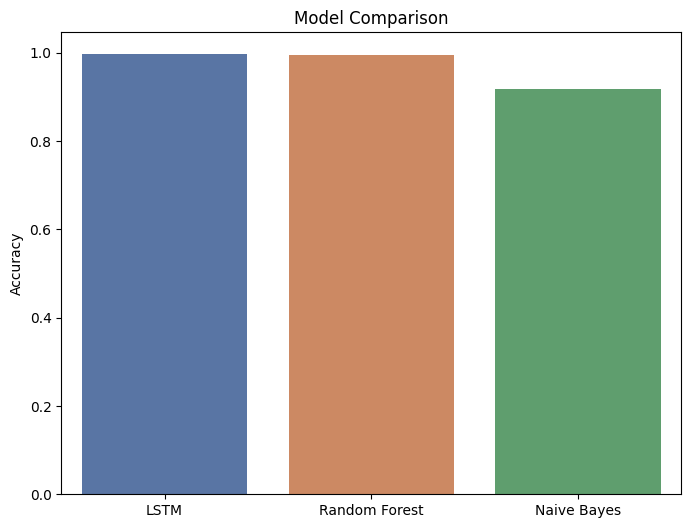

In [ ]:
def plot_bar_chart(accuracies, model_names):
    sns.barplot(x=model_names, y=accuracies, palette="deep")
    plt.ylabel("Accuracy")
    plt.title("Model Comparison")

accuracies = [accuracy, accuracy_rf, accuracy_nb]
model_names = ["LSTM", "Random Forest", "Naive Bayes"]

plt.figure(figsize=(8, 6))
plot_bar_chart(accuracies, model_names)
plt.show()

The significance of this code is that it provides a visual comparison of the performance of the three models. The bar plot shows that the LSTM model achieved the highest accuracy (0.9966), followed by the Random Forest model (0.9951), and finally the Naive Bayes model (0.9184). This comparison can help us choose the best model for our specific needs and evaluate the effectiveness of our preprocessing techniques. In this case, the LSTM and Random Forest are definitely better choices than the Naive Bayes.

Overall, the results of these analyses show that the LSTM model is the most reliable and accurate for identifying depression in social media tweets. This has important real-world applications, such as providing an automated tool for identifying individuals who may be at risk for depression and guiding them towards appropriate resources and support.

This taught us a lot about these different models and how to preprocess, analyze, and train models based on raw data. Thank you for looking through our work!